In [1]:
#Imports
import pandas as pd
from pandas import DataFrame, Series
from pandas.tseries.offsets import DateOffset
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

from pandas.tools.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

from statsmodels.graphics.tsaplots import plot_acf


from scipy.misc import imread
import arch.unitroot 




/home/theresa/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Loading Datasets

### Loading the stock price data.

In [2]:
unitedQuotes = pd.read_csv('/home/theresa/Desktop/DataSets/UnitedTweets/UALQuotesEpoch.txt')

In [3]:
unitedQuotes.head()

,EpochTime,EpochTime.1,CLOSE,HIGH,LOW,OPEN,VOLUME,first differences
0,1495719000,1495719000,79.16,79.180,79.160,79.180,6997,NaN
1,1495719060,1495719060,79.24,79.240,79.030,79.050,991,0.08
2,1495719120,1495719120,79.31,79.310,79.095,79.095,2500,0.07
3,1495719180,1495719180,79.40,79.432,79.160,79.160,2500,0.09
4,1495719240,1495719240,79.35,79.405,79.330,79.405,1200,-0.05


### Loading the tweets, which were previously analyzed for their sentiment polarity.

In [4]:
unitedTweets = pd.read_csv('/home/theresa/Desktop/DataSets/UnitedTweets/UnitedTweet_sentiment_polarity.csv')

In [5]:
unitedTweets.head()

,created_at,CleanText,Sentiment,Sentiment Category
0,2017-05-22 09:32:08-04:00,nathanoafc kfcbarstool rumour sea lion works u...,0.000,Neutral
1,2017-05-22 09:32:31-04:00,iamjohnk aminespn united airlines flight full ...,0.350,Positive
2,2017-05-22 09:33:28-04:00,united hold customer representative minutes wa...,0.000,Neutral
3,2017-05-22 09:33:32-04:00,kevwodonnell would appear snp taking pr advice...,-0.175,Neutral
4,2017-05-22 09:33:39-04:00,oldpicsarchive united airlines stewardess wi m...,0.000,Neutral


In [6]:
#unitedTimes = pd.to_datetime(unitedTweets['created_at'])
#unitedTimes = unitedTimes.tz_localize('UTC').tz_convert("US/Eastern")
unitedTweets.index = unitedTweets['created_at']
#type(unitedTweets.index)

Below, I load the 1 minute sentiment averages I computed earlier via the following code:

    sentiment1m = unitedTweets['Sentiment'].resample('1t', how='mean')
    

For the sake of the following analysis, I also filled in 0 for the sentiment of minutes not containing 
tweets about United Airlines.  (I can see arguments against doing this, but let's assume for the moment that if someone has an emotion, they tweet about it!)

I also have already added a column containing the first differences.

In [7]:
sentiment1m = pd.read_csv('/home/theresa/Desktop/DataSets/UnitedTweets/sentiment1mWithDifference')

In [8]:
sentiment1m.head()

,Unnamed: 0,Sentiment,first differences
0,0,0.175000,NaN
1,2017-05-22 09:33:00-04:00,-0.058333,-0.233333
2,2017-05-22 09:34:00-04:00,0.357143,0.415476
3,2017-05-22 09:35:00-04:00,0.000000,-0.357143
4,2017-05-22 09:36:00-04:00,0.088889,0.088889


In [9]:
sentiment1m.columns

Index(['Unnamed: 0', 'Sentiment', 'first differences'], dtype='object')

In [10]:
sentiment1m.index = sentiment1m['Unnamed: 0']
sentiment1m = sentiment1m.drop(['Unnamed: 0'], axis=1)
sentiment1m.head()

,Sentiment,first differences
Unnamed: 0,,
0,0.175000,NaN
2017-05-22 09:33:00-04:00,-0.058333,-0.233333
2017-05-22 09:34:00-04:00,0.357143,0.415476
2017-05-22 09:35:00-04:00,0.000000,-0.357143
2017-05-22 09:36:00-04:00,0.088889,0.088889


## Testing for auto-correlations

The function numpy.corrcoef calculates the Pearson coefficient of the two inputted lists.  We see below that the 1-minute change in UAL stock price can't be used to predict the next minute's change.

In [14]:
np.corrcoef(unitedQuotes['first differences'][1:-1], unitedQuotes['first differences'][2:])

array([[ 1.        ,  0.01078426],
       [ 0.01078426,  1.        ]])

Below is the graph of the first differences plotted against a lagged version of itself (here, the lag is 1).

/home/theresa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  from ipykernel import kernelapp as app


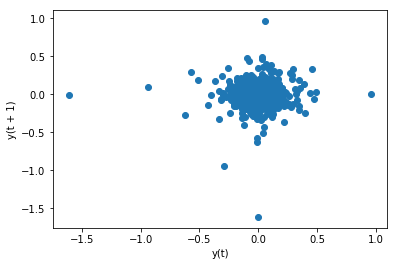

In [15]:

lag_plot(unitedQuotes['first differences'][1:], lag=1)
plt.show()


Just to make sure, I wrote the following function to see if one minute's changes could reasonably predict the change further on into the future.

In [16]:
def PearsonCoeff(list1,list2, n) :
#input two lists of equal length.  The output will be a list of the Pearson Coefficients
#when the lags are in range(1,n+1).

#the length of each list should be more than n
    correlations = []
    for i in range(1,n+1):
        corr = np.corrcoef(list1[1:-i],list2[i+1:])[0,1]
        correlations.append((i, corr))
    return correlations

In [17]:
correlations = PearsonCoeff(unitedQuotes['first differences'],unitedQuotes['first differences'],4000)

In [18]:
max(abs(y) for (x,y) in correlations)

0.11758398555740909

In [19]:
np.argmax([y for (x,y) in correlations])

2322

In [20]:
len([y for (x,y) in correlations if abs(y)>=.1])

2

There are a couple lags which lie just outside of the interval indicating 99% confidence that the first differences aren't autocorrelated.  This confidence interval is indicated on the graph by the dotted lines.

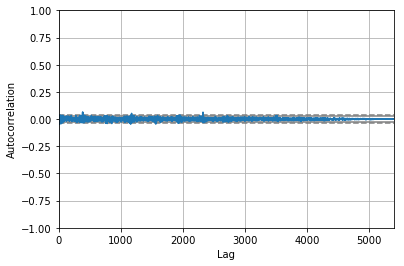

In [21]:
data = unitedQuotes['first differences'][1:]

autocorrelation_plot(data)

## Checking for stationarity vs. unit roots

#### Tests on the stock prices time-series

Below, I do two complementary tests to check for unit roots in the first differences of the UAL stock prices.  The ADF test has a null hypothesis saying that there is a unit root in the time-series, and the KPSS test has a null hypothesis that the time-series is trend-stationary.  

A miniscule p-value for the ADF and a large p-value for the KPSS together mean that it's unlikely that the time-series in question has a unit root.  A unit root would destroy the validity of standard analyses on time-series, so these results mean we can proceed without further differencing.

In [22]:
from arch.unitroot import ADF
adf = ADF(unitedQuotes['first differences'][1:], method='AIC')
print(adf.summary().as_text())
#this shows that the differences do not have a unit root

   Augmented Dickey-Fuller Results   
Test Statistic                -17.636
P-value                         0.000
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [23]:
arch.unitroot.KPSS(unitedQuotes["first differences"][1:])

Test Statistic,0.251
P-value,0.187
Lags,33


#### Tests on the differenced tweet sentiment time-series
Below, we see some evidence that there is not a unit root in the 1 minute tweeted sentiment averages after taking the first differece. Since having a unit root throws off a lot of time-series analyses, this is a good thing.

In [24]:
adf = ADF(sentiment1m['first differences'][1:], method='AIC')
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -40.482
P-value                         0.000
Lags                               50
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [25]:
arch.unitroot.KPSS(sentiment1m['first differences'][1:]) 


Test Statistic,0.001
P-value,1.000
Lags,50


At this point, neither series of first differences has unit roots, and the first differences in the stock quootes is not autocorrelated.  So now it's time to prepare the two series for Granger causality analysis.
